# Multi-track hit classification with CNNs

Let's see how well the conv net model(s) can disambiguate hits into multiple track assignments.

As with the LSTM_Toy_MultiTrack fomulation, the data structure is basically an image with channels for each track plus a channel for the raw event data.

In [92]:
# System imports
from __future__ import print_function

# External imports
import numpy as np
from keras import models
from keras import layers
from matplotlib import pyplot as plt

# Local imports
from data import (generate_straight_track, generate_straight_tracks,
                  generate_uniform_noise, generate_track_bkg)
from drawing import draw_2d_input_and_pred, draw_2d_event
from metrics import calc_hit_accuracy

%matplotlib notebook

## Utilities

In [71]:
def draw_train_history(history, figsize=(9,4)):
    train_accs = [np.array(history.history[k]) for k in history.history.keys()
                  if not k.startswith('val') and '_acc' in k]
    val_accs = [np.array(history.history[k]) for k in history.history.keys()
                if k.startswith('val') and '_acc' in k]
    has_val = len(val_accs) > 0
    avg_train_acc = sum(train_accs) / len(train_accs)
    if has_val:
        avg_val_acc = sum(val_accs) / len(val_accs)
    # Plot the loss
    fig = plt.figure(figsize=figsize)
    plt.subplot(121)
    epochs = history.epoch
    plt.plot(epochs, history.history['loss'], label='Training set')
    if has_val:
        plt.plot(epochs, history.history['val_loss'], label='Validation set')
    plt.title('Loss')
    plt.legend(loc=0)
    plt.xlabel('Training epoch')
    plt.ylabel('Loss')
    # Plot the accuracy
    plt.subplot(122)
    plt.plot(epochs, avg_train_acc, label='Training set average')
    if has_val:
        plt.plot(epochs, avg_val_acc, label='Validation set average')
    plt.ylim((0,1))
    plt.title('Accuracy')
    plt.xlabel('Training epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc=0)
    plt.tight_layout()
    return fig

def draw_outputs(event, preds, figsize=(11,4), nrows=1, ncols=3):
    fig = plt.figure(figsize=figsize)
    # Draw the input
    plt.subplot(nrows, ncols, 1)
    draw_2d_event(event, title='Model input')
    # Draw each of the outputs
    for itrk in range(len(preds)):
        plt.subplot(nrows, ncols, itrk+2)
        draw_2d_event(preds[itrk], title='Model prediction %i' % itrk)
    return fig

def history_report(history):
    """Report on the final loss and accuracies"""
    keys = sorted(history.history.keys())
    print('Final losses')
    print('  train: %g' % history.history['loss'][-1])
    try:
        print('  valid: %g' % history.history['val_loss'][-1])
    except KeyError:
        pass
    print('Final accuracies')
    for key in keys:
        if '_acc' in key:
            print('  %s: %g' % (key, history.history[key][-1]))

## Data generation

In [105]:
def generate_data(num_event, det_shape, num_sig_tracks, seed_size, noise_prob):
    """Generate some data"""
    sig_tracks = [generate_straight_tracks(num_event, det_shape)
                  for _ in range(num_sig_tracks)]
    noise = generate_uniform_noise(num_event, det_shape, prob=noise_prob, 
                                   skip_layers=seed_size)
    return sig_tracks, noise

def batch_generator(num_batch, det_shape, num_sig_tracks, seed_size, noise_prob=0):
    """Function for generating batches of data while training"""
    while True:
        # tracks is a list of tensors; noise is one tensor
        tracks, noise = generate_data(num_batch, det_shape, num_sig_tracks,
                                      seed_size=seed_size, noise_prob=noise_prob)        
        inputs = []
        # Specify the seeds as inputs
        for i in range(num_sig_tracks):
            inputs.append(np.zeros((num_batch,) + det_shape))
            inputs[i][:,:seed_size,:] = tracks[i][:,:seed_size,:]
        # Now give the full event also as input
        inputs.append(sum(tracks + [noise]))
        # Targets are just the track tensors
        targets = tracks
        yield (inputs, targets)

In [4]:
# Detector configuration
det_width = 32
det_depth = 10
det_shape = (det_depth, det_width)
seed_size = 3

## Models

In [7]:
def build_conv_model(det_shape, num_tracks):
    """A conv model which does per-channel softmax over pixels in a layer"""
    det_depth, det_width = det_shape
    # Separate input channels
    inputs = [layers.Input(shape=det_shape) for i in range(num_tracks+1)]
    # Add a channel dimension before merging
    reshape_layer = layers.Reshape((1,) + det_shape)
    shaped_inputs = [reshape_layer(i) for i in inputs]
    # Merge into one multi-channel image
    hidden = layers.merge(shaped_inputs, mode='concat', concat_axis=1)
    # Apply some convolutions
    for i in range(10):
        hidden = layers.Conv2D(16, 3, 3, border_mode='same', activation='relu')(hidden)
    # Final convolution without activation
    hidden = layers.Conv2D(num_tracks, 3, 3, border_mode='same')(hidden)
    # Split output channels
    split_outputs = [layers.Lambda(lambda x: x[:,i])(hidden) for i in range(num_tracks)]
    # Apply softmax to each layer
    softmax_layer = layers.TimeDistributed(layers.Activation('softmax'))
    outputs = [softmax_layer(o) for o in split_outputs]
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

def build_convae_model(det_shape, num_tracks=2):
    """A conv model which does per-channel softmax over pixels in a layer"""
    det_depth, det_width = det_shape
    # Separate input channels
    inputs = [layers.Input(shape=det_shape) for i in range(num_tracks+1)]
    # Add a channel dimension before merging
    reshape_layer = layers.Reshape((1,) + det_shape)
    shaped_inputs = [reshape_layer(i) for i in inputs]
    # Merge into one multi-channel image
    hidden = layers.merge(shaped_inputs, mode='concat', concat_axis=1)

    # Apply some convolutions
    conv_args = dict(border_mode='same', activation='relu')
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(32, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(64, 3, 3, **conv_args)(hidden)
    hidden = layers.MaxPooling2D((2, 2), border_mode='same')(hidden)
    hidden = layers.Conv2D(64, 3, 3, **conv_args)(hidden)

    # Convolutions and up-sampling
    hidden = layers.UpSampling2D((2, 2))(hidden)
    hidden = layers.Conv2D(64, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    hidden = layers.Conv2D(32, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    hidden = layers.Conv2D(16, 3, 3, **conv_args)(hidden)
    hidden = layers.UpSampling2D((2, 2))(hidden)
    hidden = layers.Conv2D(8, 3, 3, **conv_args)(hidden)

    # Final convolution without activation
    hidden = layers.Conv2D(num_tracks, 3, 3, border_mode='same')(hidden)

    # Split output channels
    split_outputs = [layers.Lambda(lambda x: x[:,i])(hidden) for i in range(num_tracks)]

    # Apply softmax to each layer
    softmax_layer = layers.TimeDistributed(layers.Activation('softmax'))
    outputs = [softmax_layer(o) for o in split_outputs]

    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

## Basic conv network model

In [73]:
# Data configuration
num_event = 5120000
num_tracks = 5
noise_prob = 0

# Training configuration
num_epoch = 20
ev_per_epoch = num_event / num_epoch
batch_size = 128

In [74]:
# Compile the model
model0 = build_conv_model(det_shape, num_tracks=num_tracks)
#model0.summary()

# Fit the training data
batch_gen = batch_generator(batch_size, det_shape, num_tracks, seed_size)
history0 = model0.fit_generator(batch_gen, samples_per_epoch=ev_per_epoch, nb_epoch=num_epoch)

Epoch 1/20
256000/256000 [==============================] - 76s - loss: 3.3470 - timedistributed_6_loss: 0.6737 - timedistributed_6_acc: 0.7329    
Epoch 2/20
256000/256000 [==============================] - 75s - loss: 1.4833 - timedistributed_6_loss: 0.3114 - timedistributed_6_acc: 0.8708    
Epoch 3/20
256000/256000 [==============================] - 76s - loss: 1.6833 - timedistributed_6_loss: 0.3573 - timedistributed_6_acc: 0.8535    
Epoch 4/20
256000/256000 [==============================] - 76s - loss: 1.0765 - timedistributed_6_loss: 0.2257 - timedistributed_6_acc: 0.9032    
Epoch 5/20
256000/256000 [==============================] - 76s - loss: 0.9364 - timedistributed_6_loss: 0.1942 - timedistributed_6_acc: 0.9185    
Epoch 6/20
256000/256000 [==============================] - 76s - loss: 0.7879 - timedistributed_6_loss: 0.1608 - timedistributed_6_acc: 0.9314    
Epoch 7/20
256000/256000 [==============================] - 76s - loss: 0.7322 - timedistributed_6_loss: 0.1488 

Final losses
  train: 0.571696
Final accuracies
  timedistributed_6_acc: 0.951077


<IPython.core.display.Javascript object>


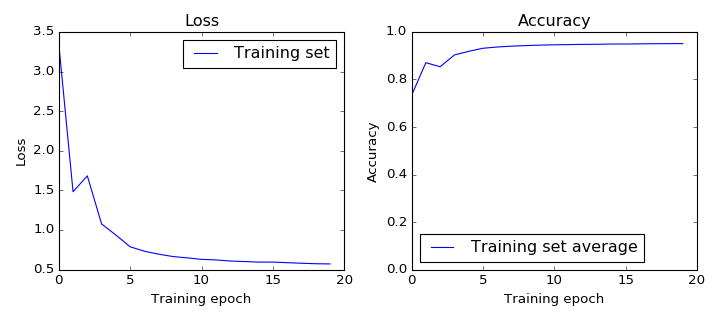

In [75]:
history_report(history0)
fig0 = draw_train_history(history0)

## Evaluate a test set

In [88]:
# Test set configuration
num_test = 512

In [89]:
# Create the test set
test_input, test_target = batch_generator(
    num_test, det_shape, num_tracks, seed_size).next()
test_events = test_input[-1]

In [90]:
# Evaluate the model
test_preds = model0.predict(test_input, batch_size=batch_size)

In [116]:
# Reshape data for accuracy function
test_preds_flat = np.concatenate(test_preds)
test_target_flat = np.concatenate(test_target)

# Repeat the events for every track, for convenience when calculating accuracy
test_events_flat = np.concatenate([test_events] * num_tracks)

In [169]:
# Hit prediction accuracy
pixel_accuracy = calc_hit_accuracy(test_preds_flat, test_target_flat,
                                   num_seed_layers=seed_size)
# Hit classification accuracy
test_scores = test_preds_flat * test_events_flat
hit_accuracy = calc_hit_accuracy(test_scores, test_target_flat)
print('Accuracy of predicted pixel:', pixel_accuracy)
print('Accuracy of classified hit: ', hit_accuracy)

Accuracy of predicted pixel: 0.933537946429
Accuracy of classified hit:  0.9523828125


<IPython.core.display.Javascript object>


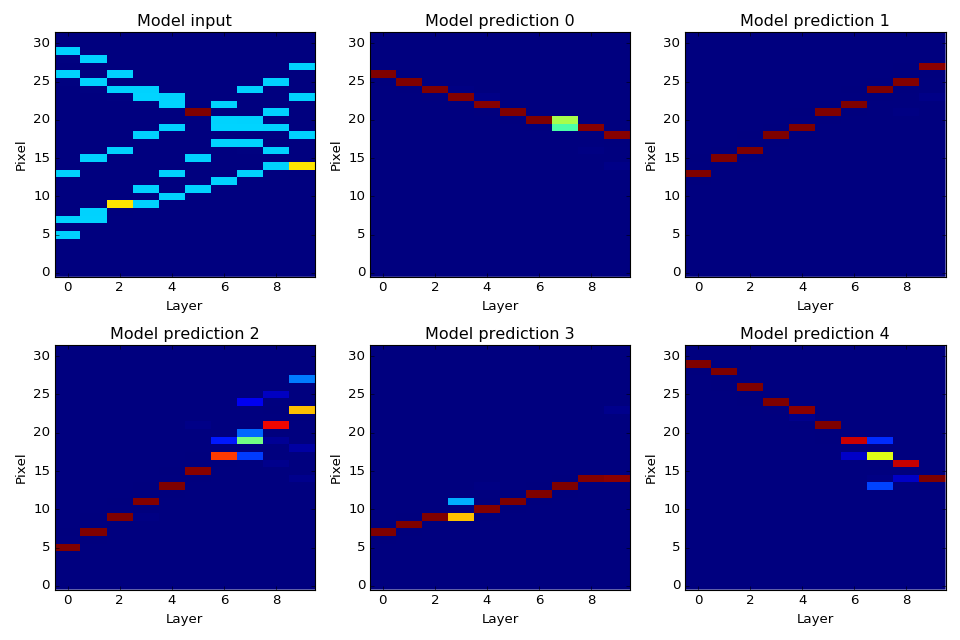

In [172]:
ievt = 0
fig1 = draw_outputs(test_events[ievt], [p[ievt] for p in test_preds], figsize=(12,8), nrows=2)